#  Create co-accessibility networks from scATAC-seq data using Cicero
**Authorship:** Adam Klie (last updated: 08/14/2023)<br>
***
**Description:** This notebooks performs the base GRN construction step for CellOracle using Cicero
***

# Set-up

In [ ]:
# Load libraries
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(dplyr))
suppressMessages(library(stringr))
suppressMessages(library(cicero))
suppressMessages(library(monocle3))

# Saving params
library(yaml)

ERROR: Error in library(monocle3): there is no package called 'monocle3'


In [28]:
# General info
dataset_name <- "igvf_sc-islet_10X-Multiome"
now <- "10Aug23"
analysis <- "base_grn_construction"
platinum_dir <- "/cellar/users/aklie/data/igvf/beta_cell_networks/platinum"
celloracle_dir <- "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results"

# File paths
in_dir <- file.path(platinum_dir, dataset_name, now, "scATAC")
out_dir <- file.path(celloracle_dir, dataset_name, now, analysis)

# Run paramters
binarize <- TRUE
max_count <- 20000
min_count <- 2000
reduced_coords <- "TODO: add file path"
chromsizes_file <- "/cellar/shared/carterlab/genomes/hg38/hg38.chrom.sizes"
metacell_nn <- 30
distance_estimate_window <- 1e6
distance_estimate_maxit <- 100
distance_estimate_sample_num <- 100 
distance_estimate_distance_constraint <- 500000

[1] "/cellar/users/aklie/data/igvf/beta_cell_networks/platinum/igvf_sc-islet_10X-Multiome/10Aug23/scATAC"

# Make a cell_data_set CDS

In [31]:
# Read in the sparseMatrix object
indata <- readMM(file.path(in_dir, "matrix.mtx.gz"))
dim(indata)

[1] 262611  83289

In [ ]:
# Binarize the matrix
indata@x[indata@x > 0] <- 1

In [46]:
# Read in the cell barcodes
read_cells <- function(file.path) {
    cellinfo <- read.table(file.path)
    row.names(cellinfo) <- cellinfo$V1
    names(cellinfo) <- "cells"
}
read_cells(file.path(in_dir, "/barcodes.tsv.gz"))
print(dim(cellinfo))
head(cellinfo)

[1] 83289     1


,cells
,<chr>
MO1_AAACAGCCAGCAATAA-1,MO1_AAACAGCCAGCAATAA-1
MO1_AAACCAACAACCGCCA-1,MO1_AAACCAACAACCGCCA-1
MO1_AAACCGCGTATTGTGG-1,MO1_AAACCGCGTATTGTGG-1
MO1_AAACGCGCAAGCCACT-1,MO1_AAACGCGCAAGCCACT-1
MO1_AAACGCGCAGTTATCG-1,MO1_AAACGCGCAGTTATCG-1
MO1_AAACGTACACCAGCAT-1,MO1_AAACGTACACCAGCAT-1


In [47]:
# Read in the peak information
read_peaks <- function(file_path) {
    
    # Read in the peaks from the file_path
    peakinfo <- read.table(file_path)

    # Only keep the first column, but keep it a data frame
    peakinfo <- peakinfo[,1, drop=FALSE]

    # Split this column on "-"
    peakinfo <- data.frame(do.call("rbind", strsplit(as.character(peakinfo$V1), "-")))

    # Make names for the columns
    names(peakinfo) <- c("chr", "bp1", "bp2")

    # Creat site name column
    peakinfo$site_name <- paste(peakinfo$chr, peakinfo$bp1, peakinfo$bp2, sep="_")

    # Make the site name the row names
    row.names(peakinfo) <- peakinfo$site_name

    # Return the peakinfo data frame
    return(peakinfo)
}
peakinfo <- read_peaks(file.path(in_dir, "features.tsv.gz"))
print(dim(peakinfo))
head(peakinfo)

[1] 262611      4


,chr,bp1,bp2,site_name
,<chr>,<chr>,<chr>,<chr>
chr1_9720_10674,chr1,9720,10674,chr1_9720_10674
chr1_28830_29744,chr1,28830,29744,chr1_28830_29744
chr1_180609_181647,chr1,180609,181647,chr1_180609_181647
chr1_183869_184817,chr1,183869,184817,chr1_183869_184817
chr1_186252_187321,chr1,186252,187321,chr1_186252_187321
chr1_191010_191989,chr1,191010,191989,chr1_191010_191989


In [48]:
# Make the row and column names of the input data consistent with the peak and cell information
row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)

In [66]:
input_cds <- suppressWarnings(newCellDataSet(
    cellData=indata,
    methods::new('AnnotatedDataFrame', data = cellinfo),
    featureData = methods::new('AnnotatedDataFrame', data = peakinfo),
    expressionFamily=negbinomial.size(),
    lowerDetectionLimit=0
))

In [67]:
# Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,]

In [68]:
# Get cell counts
cell_counts <- Matrix::colSums(exprs(input_cds))
head(cell_counts)

MO1_AAACAGCCAGCAATAA-1 MO1_AAACCAACAACCGCCA-1 MO1_AAACCGCGTATTGTGG-1 
                  6163                  17052                   8652 
MO1_AAACGCGCAAGCCACT-1 MO1_AAACGCGCAGTTATCG-1 MO1_AAACGTACACCAGCAT-1 
                 16747                  11440                   5972

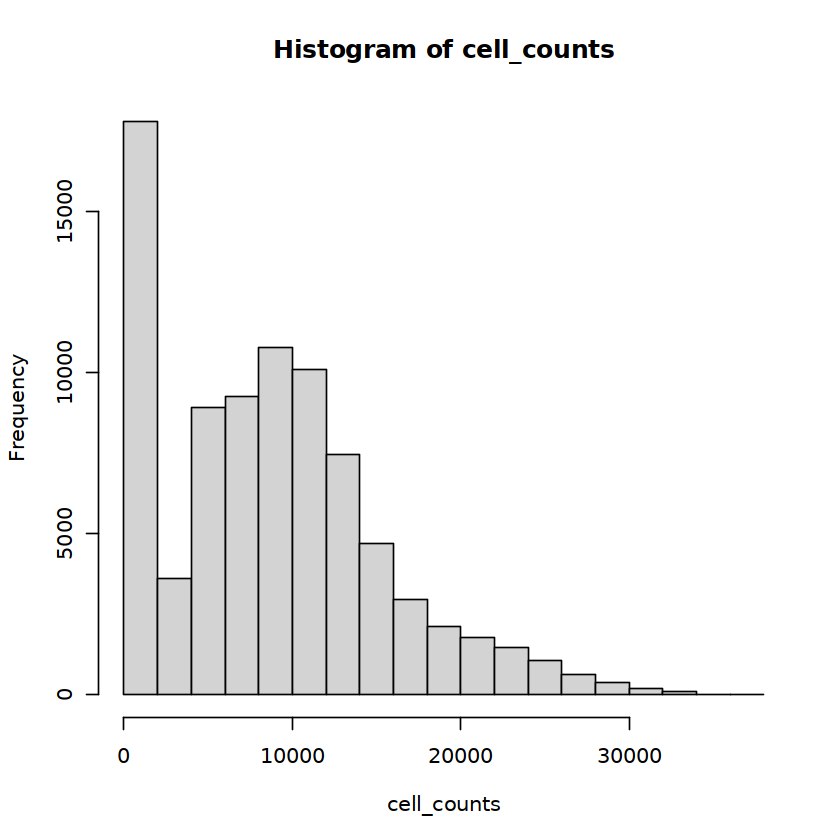

In [69]:
# Visualize peak_count_per_cell
hist(cell_counts)

In [70]:
# Filter cells by peak_count
max_count <- 20000
min_count <- 2000
keep_cells <- (cell_counts > min_count) & (cell_counts < max_count)

In [ ]:
seurat_dir <- "/cellar/users/aklie/data/igvf/beta_cell_networks/seurat/"
in_dir <- file.path(seurat_dir, dataset_name, now)
rds_path <- file.path(in_dir, "year1_year2_all.rds")
adata <- readRDS(rds_path)
adata

In [71]:
umap_coords <- Embeddings(adata[['umap.wnn']])
colnames(umap_coords) <- NULL

In [72]:
input_cds <- input_cds[, keep_cells]
umap_coords <- umap_coords[keep_cells, ]

In [73]:
dim(input_cds)

Features  Samples 
  262611    59865

In [74]:
dim(umap_coords)

[1] 59865     2

In [75]:
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords, k=30)

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 26
Mean shared cells bin-bin: 0.014412517993953
Median shared cells bin-bin: 0

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 9.2 GiB"


In [78]:
cicero_cds

CellDataSet (storageMode: environment)
assayData: 262611 features, 4692 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: agg26020 agg20452 ... agg27467 (4692 total)
  varLabels: agg_cell Size_Factor num_genes_expressed
  varMetadata: labelDescription
featureData
  featureNames: chr1_9720_10674 chr1_28830_29744 ...
    chrY_56836290_56837298 (262611 total)
  fvarLabels: chr bp1 ... num_cells_expressed (5 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [79]:
run_cicero <- function(cicero_cds, umap_coords, celltype){
    window <- 1e6
    chromsizes <- "/cellar/shared/carterlab/genomes/hg38/hg38.chrom.sizes"
    distance_parameters <- estimate_distance_parameter(cicero_cds, window=window, maxit=100, sample_num=100, distance_constraint=500000, genomic_coords=chromsizes)
    mean_distance_parameter <- mean(unlist(distance_parameters))
    cicero_out <- generate_cicero_models(cicero_cds, distance_parameter=mean_distance_parameter, window=window, genomic_coords=chromsizes)
    conns <- assemble_connections(cicero_out, silent=FALSE)
    return(conns)
}

In [80]:
cicero_conns <- run_cicero(cicero_cds, umap_coords, 'global')

In [ ]:
cicero_conns

In [ ]:
out_dir <- file.path(celloracle_dir, dataset_name, now, analysis)

In [ ]:
# Creat directories for writing out
dir.create(out_dir, showWarnings = TRUE, recursive = TRUE)

In [ ]:
write.csv(x = conns, file = file.path(output_folder, "cicero_connections.csv"))

In [ ]:
saveRDS(cicero_cds, file = file.path(output_folder, "/cicero_connections.csv"))

In [ ]:
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = file.path(output_folder, "/all_peaks.csv"))

# DONE!

---